In [1]:
#load game core
%run -i DraughtsGameCore.py
%run -i AIPlayers.py

In [2]:
from DraughtsGameCore import *
from AIPlayers import *
from gym import Env
from gym.spaces import Discrete,Dict
import numpy as np
import random
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

/Users/zhangliu/opt/miniconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/zhangliu/opt/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/zhangliu/opt/miniconda3/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/zhangliu/opt/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
def BoardToStr(board):
    value=""
    for x in range(8):
        for y in range(8):
            if (x+y)%2==1:
                if board[x][y]!=DARK_SQUARE:
                    value+="{0},{1},{2}-".format(x,y,board[x][y])
    return value

def StrToBoard(str):
    blankBorad=[[(WHITE_SQUARE if y%2==0 else DARK_SQUARE )if x%2==0 else (DARK_SQUARE if y%2==0 else WHITE_SQUARE) for y in range(NColumn)] for x in range(NRow)]
    #vv=["1,2,1","2,1,2",...]
    for vv in str.split('-'):
        if vv=="":
            continue
        else:
            #vvv=["1","2","1"]
            vvv=vv.split(",")
            blankBorad[int(vvv[0])][int(vvv[1])]=vvv[2]
    return blankBorad
                

In [4]:
RANDOM_PLAYER=True
#gym environment
class ShowerEnv(Env):
    def __init__(self):
        #init game
        self.game=Draughts(PLAYER2_SYMBOL)
        #all possible game state with movement
        self.possible_states=self.game.Movement(self.game.board,self.game.current_player)
        # Actions
        self.action_space = Discrete(len(self.possible_states))
        # map 2-dimension array to a string ID
        self.board_ID=BoardToStr(self.game.board)
        # 
        self.observation_space = Dict({self.board_ID:Discrete(1)})
        # Set start temp
        self.state = self.board_ID
        self.player=MiniMaxPlayer(PLAYER1_SYMBOL,1,"MINIMAX AI")
        
    def step(self, action):
        # Apply action
        selected_board=self.possible_states[action][:NRow]
        self.game.update(selected_board)

        info={}

        if self.game.isGameOver():
            reward=self.game.evalState(selected_board)
            done=True
            info = {"winner":self.game.getWinner(self.game.board)}
            return "",reward,done,info
        else:
            done=False
        

        possible_states=self.game.Movement(self.game.board,PLAYER1_SYMBOL)
        #opponent player
        if RANDOM_PLAYER:
            player1_action_index=random.randint(0,len(possible_states)-1)
            player1_selected_board=possible_states[player1_action_index][:NRow]
        else:
            # Minimax player
            board_move=self.player.chooseMove(self.game,possible_states)
            player1_selected_board=board_move[0]

        self.game.update(player1_selected_board)
        self.state = BoardToStr(player1_selected_board)

        if self.game.isGameOver():
            reward=self.game.evalState(player1_selected_board)
            done=True
            info = {"winner":self.game.getWinner(self.game.board)}
            return "",reward,done,info
        else:
            done=False

        # Calculate reward
        reward=self.game.evalState(player1_selected_board)
        # print("reward: {0}".format(reward))

        #for player 2
        self.possible_states=self.game.Movement(self.game.board,PLAYER2_SYMBOL)
        self.action_space = Discrete(len(self.possible_states))
        # Temperature array
        self.board_ID=BoardToStr(self.game.board)
        self.observation_space = Dict({self.board_ID:Discrete(1)})

        # Return step information
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        #init game
        self.game=Draughts(PLAYER2_SYMBOL)
        #all possible game state with movement
        self.possible_states=self.game.Movement(self.game.board,self.game.current_player)[:NRow]
        self.action_space = Discrete(len(self.possible_states))
        # Temperature array
        self.board_ID=BoardToStr(self.game.board)
        self.observation_space = Dict({self.board_ID:Discrete(1)})
        # Set start temp
        self.state = self.board_ID
        return self.state
    

env = ShowerEnv()

In [ ]:
#Random player vs Random player
episodes = 1000
winner=[]
episode=[]
player2_reward=[]
for e in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    # print('Episode:{} Score:{} {}'.format(e, score,info))

    episode.append(e)
    winner.append(int(info["winner"]))
    player2_reward.append(score)

# print(episode)
# print(winner)
# print(player2_reward)

In [11]:
random_play=pd.DataFrame()
random_play["episode"]=episode
random_play["winner"]=winner
random_play["player2_reward"]=player2_reward
random_play

,episode,winner,player2_reward
0,1,2,-142.5
1,2,1,221.5
2,3,2,-152.5
3,4,2,-265.5
4,5,1,111.0
...,...,...,...
995,996,2,-113.0
996,997,1,64.0
997,998,2,-1264.0
998,999,2,-157.0


Text(0, 0.5, 'Number of games won')

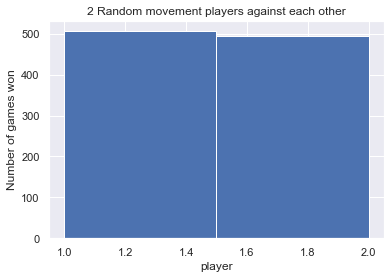

In [12]:
random_play["winner"].hist(bins=2)
plt.title("2 Random movement players against each other")
plt.xlabel("player")
plt.ylabel("Number of games won")

In [5]:
# Q-learning training with random player
alpha = 0.1
gamma = 0.6
epsilon = 0.2
q_table = {}

num_of_episodes = 1000

def updateQtable(state,action,reward):
    if state not in q_table.keys():
        q_table[state]={}
    
    if action not in q_table[state]:
        q_table[state][action]=reward
        return

    q_table[state][action]=reward
    return
    
def getMaxQtableValue(state):
    if state not in q_table.keys():
        return 0

    valueList=list(q_table[state].values())
    maxIndex=np.argmax(valueList)
    action=list(q_table[state].keys())[maxIndex]
    
    return action

def getQtableValue(state,action):
    if state not in q_table.keys():
        return 0
    if action not in q_table[state]:
        return 0
    v=q_table[state][action]
    return v

s_time=time.time()
for episode in range(0, num_of_episodes):
    # Reset the enviroment
    state = env.reset()

    # Initialize variables
    reward = 0
    done = False
    
    
    while not done:
        # Take learned path or explore new actions based on the epsilon
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = getMaxQtableValue(state)

        # Take action    
        next_state, reward, done, info = env.step(action) 
        
        # Recalculate
        q_value = getQtableValue(state,action)
        max_value = getMaxQtableValue(state)
        new_q_value = (1 - alpha) * q_value + alpha * (reward + gamma * max_value)
        
        # Update Q-table
        # q_table[state, action] = new_q_value
        updateQtable(state,action,new_q_value)
        state = next_state
    if (episode + 1) % 100 == 0:
        print("Episode: {} duration: {:.3f}".format(episode + 1,time.time()-s_time))
        s_time=time.time()

print("**********************************")
print("{} episodes Q-Learning Training is done!\n".format(num_of_episodes))
print("**********************************")

Episode: 100 duration: 8.492
Episode: 200 duration: 8.659
Episode: 300 duration: 8.835
Episode: 400 duration: 9.081
Episode: 500 duration: 9.417
Episode: 600 duration: 9.388
Episode: 700 duration: 9.459
Episode: 800 duration: 9.547
Episode: 900 duration: 9.199
Episode: 1000 duration: 9.112
**********************************
1000 episodes Q-Learning Training is done!

**********************************


In [16]:
#Random Player(player 1) versus Q-Learning(player 2)
total_epochs = 0
num_of_episodes = 100

winner=[]
episode=[]
player2_reward=[]

for _ in range(num_of_episodes):
    state = env.reset()
    epochs = 0
    penalties = 0
    reward = 0
    
    done = False
    
    while not done:
        action = getMaxQtableValue(state)
        state, reward, done, info = env.step(action)

        epochs += 1

    episode.append(e)
    winner.append(int(info["winner"]))
    player2_reward.append(score)

print("**********************************")
print("Random player (player 1) versus Q-learning(player 2) is done ")
print("**********************************")

**********************************
Random player (player 1) versus Q-learning(player 2) is done 
**********************************


Text(0, 0.5, 'Number of games won')

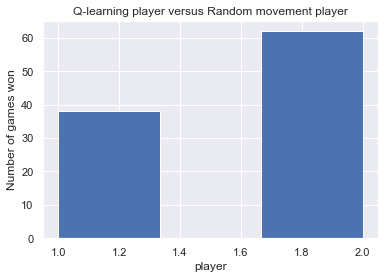

In [17]:
random_play=pd.DataFrame()
random_play["episode"]=episode
random_play["winner"]=winner
random_play["player2_reward"]=player2_reward
random_play["winner"].hist(bins=3)
plt.title("Q-learning player 2 versus Random movement player 1")
plt.xlabel("player")
plt.ylabel("Number of games won")

In [7]:
#Minimax Player (player 1) versus Q-Learning player (player 2)
RANDOM_PLAYER=False

total_epochs = 0
num_of_episodes = 100

winner=[]
episode=[]
player2_reward=[]

for e in range(num_of_episodes):
    state = env.reset()
    epochs = 0
    penalties = 0
    reward = 0
    
    done = False
    
    while not done:
        action = getMaxQtableValue(state)
        state, reward, done, info = env.step(action)

    episode.append(e)
    winner.append(int(info["winner"]))
    player2_reward.append(reward)

print("**********************************")
print("Minimax Player (player 1) versus Q-Learning player (player 2)")
print("**********************************")


KeyboardInterrupt: 

In [ ]:
MQ=pd.DataFrame()
MQ["episode"]=episode
MQ["winner"]=winner
MQ["player2_reward"]=player2_reward
MQ

In [ ]:
MQ["winner"].hist(bins=3)
plt.title("Minimax Player (player 1) versus Q-Learning player (player 2)")
plt.xlabel("player")
plt.ylabel("Number of games won")